In [ ]:
import torch
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Did not find {image_path} directory, creating one")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data...")
  f.write(request.content)

# Unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data")
  zip_ref.extractall(image_path)
  print("Complete!")

data/pizza_steak_sushi directory exists
Unzipping data
Complete!


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza.


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/sushi/268990.jpg
Image class: sushi
Image height: 512
Image width: 384


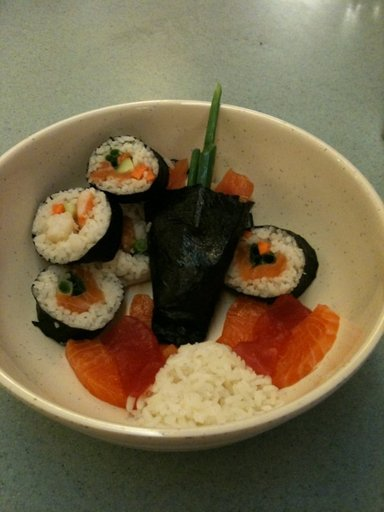

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

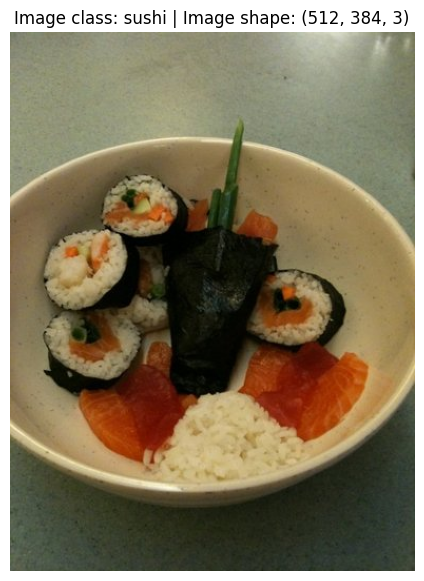

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False);

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Write a transform for image
data_transform = transforms.Compose([
    # Resize image to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

# Option 1: Loading image data using ImageFolder


In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
img, label = train_data[0][0], train_data[0][1]

In [ ]:
class_names[label]

'pizza'

In [ ]:
img.shape

torch.Size([3, 64, 64])

In [ ]:
"""
Turn loaded images into DataLoader
A DataLoader is going to help us turn our Dataset
into iterables and we can customize the batch size so
our model can see batch_size images at a time
""";

In [ ]:
import os
os.cpu_count()

2

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7afaf4a3f470>,
 <torch.utils.data.dataloader.DataLoader at 0x7af9e911a7b0>)

## Option 2: Loading image data with a custom Dataset

1. Want to be able to load image from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get class as dictionary from the dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
# We are trying to mimick this implementation
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Create a custom Dataset to replicate ImageFolder

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes:
   - **paths**: paths of our images  
   - **transform**: the transform we'd like to use  
   - **classes**: a list of the target classes  
   - **class_to_idx**: a dict of the target classes mapped to integer labels  
4. Create a function `load_images()`, this function will open an image  
5. Overwrite the `__len__()` method to return the length of our dataset  
6. Overwrite the `__getitem__()` method to return a given sample when passed an index  


In [ ]:
from torch.utils.data import Dataset

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""

  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

class ImageFolderCustom(Dataset):
  def __init__(self,
              targ_dir: str,
              transform=None):
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Set up transform (optional)
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
      "Opens an image via a path and returns it."
      image_path = self.paths[index]
      return Image.open(image_path)

  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)


In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7af9e9148470>,
 <__main__.ImageFolderCustom at 0x7af9e9118980>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Turn custom loaded images into DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     num_workers=NUM_WORKERS,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    num_workers=NUM_WORKERS,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7af9e911b4a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7afaf4a3eab0>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    """Benefits from operator fusion (faster compute)"""
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [ ]:
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data)).to(device)
summary(model_1, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 225]                  --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [ ]:
"""
Loss and Backward in PyTorch

Loss output
- Loss functions usually return a **scalar tensor** (dim 0, `torch.Size([])`)
- This happens because they apply a reduction (`mean` or `sum`) across the batch

Backward requirement
- `.backward()` works directly on scalars
- If the output is not a scalar (vector/matrix), you must pass a gradient argument

What `.backward()` does
- Traces back through the **computation graph** of how the loss was created
- Applies the **chain rule** step by step
- Stores gradients in each parameter’s `.grad` attribute

Why scalar loss is used
- One number summarises “how wrong” the model is
- Makes `.backward()` straightforward without extra arguments
""";

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put model in train mode
  model.train()

  # Set up train loss and train accuracy
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # 1. Forward Pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update weights)
    optimizer.step()

    # Calculate accuracy metrics
    """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
    """softmax is just for prediction probabilites and not necessary, can just argmax"""
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in train mode
  model.eval()

  # Set up train loss and train accuracy
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
  # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate accuracy metrics
      test_pred_labels = torch.argmax(test_pred_logits, dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train Loss: {train_loss} | Train Acc: {train_acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_augmented = ImageFolderCustom(targ_dir=train_dir,
                                         transform=train_transform_trivial)

test_data_simple = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform_simple)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        num_workers=NUM_WORKERS,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    num_workers=NUM_WORKERS,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 4.794492125511169 | Train Acc: 0.37109375 | Test Loss: 3.6369144121805825 | Test Acc: 0.3229166666666667
Epoch: 1 | Train Loss: 2.225141227245331 | Train Acc: 0.40234375 | Test Loss: 1.0976544419924419 | Test Acc: 0.3333333333333333
Epoch: 2 | Train Loss: 1.193876937031746 | Train Acc: 0.27734375 | Test Loss: 1.052271048227946 | Test Acc: 0.5009469696969697
Epoch: 3 | Train Loss: 1.1453334391117096 | Train Acc: 0.30859375 | Test Loss: 1.0952038963635762 | Test Acc: 0.3503787878787879
Epoch: 4 | Train Loss: 1.1860645115375519 | Train Acc: 0.3359375 | Test Loss: 1.0176602800687153 | Test Acc: 0.39015151515151514
Total training time: 11.553 seconds


In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

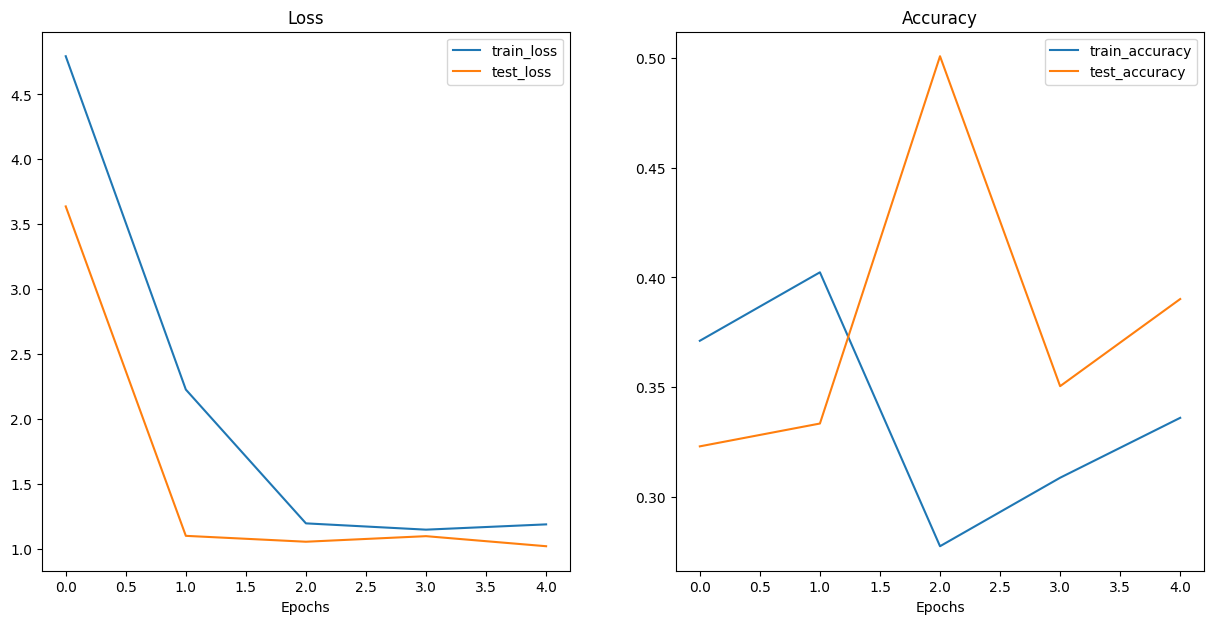

In [ ]:
plot_loss_curves(model_1_results)